Starting model training...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters found: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}

Feature Importance:
             Feature  Importance
0                σcc    0.413282
1  Axial Load Effect    0.223296
3          RI Term 1    0.187154
4          RI Term 2    0.102712
5              Gamma    0.073556
2    Geometric Terms    0.000000

Model Performance Metrics:
                 Dataset        R²  Mean Absolute Percentage Error (%)
0             Validation  0.980852                            5.395264
1  Training + Validation  0.974363                            5.272539
2                   Test  0.903426                            8.516716
Number of data points plotted (Training + Validation Set): 105


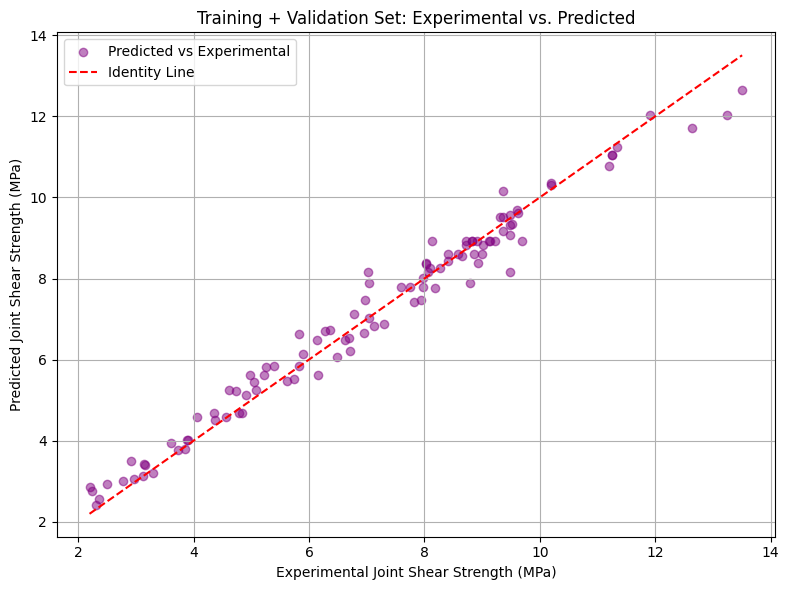

Number of data points plotted (Test Set): 27


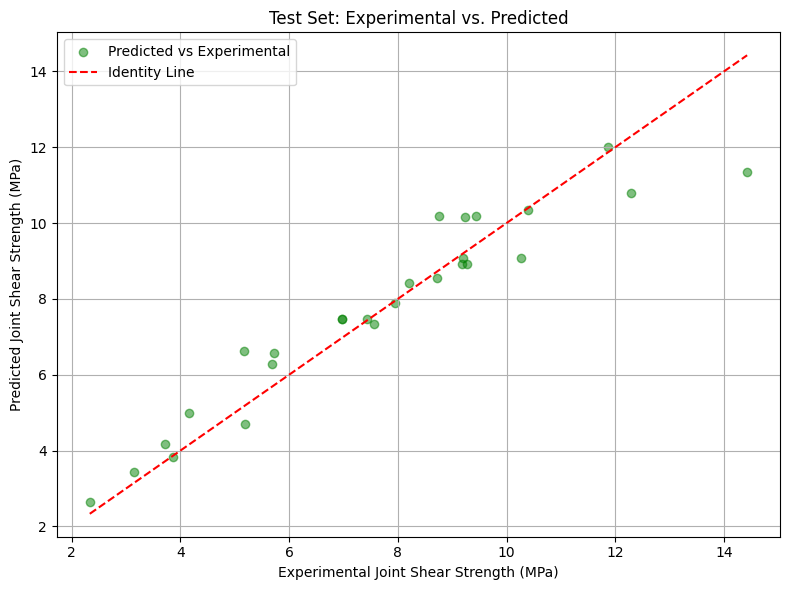

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

data = pd.read_excel('PythonDatabase.xlsx')
data.columns = data.columns.str.strip()

if 'gamma' in data.columns and 'jointtype' in data.columns:
    coefficients = {
        'Exterior': {'alpha': 0.25, 'beta': 0.75, 'gamma': 1.50, 
                    'C1': 0.30, 'C2': -1.10, 'C3': -0.20, 'C4': -0.70, 'C5': 2.00, 'C6': 0.50},
        'Interior': {'alpha': 0.00, 'beta': 1.00, 'gamma': 2.10, 
                    'C1': 0.30, 'C2': -1.10, 'C3': -0.20, 'C4': -0.70, 'C5': 2.00, 'C6': 0.50}
    }
    
    data['alpha'] = data['jointtype'].map(lambda jt: coefficients[jt]['alpha'])
    data['beta'] = data['jointtype'].map(lambda jt: coefficients[jt]['beta'])
    data['gamma'] = data['jointtype'].map(lambda jt: coefficients[jt]['gamma'])
    data['C1'] = coefficients['Exterior']['C1']  
    data['C2'] = coefficients['Exterior']['C2']
    data['C3'] = coefficients['Exterior']['C3']
    data['C4'] = coefficients['Exterior']['C4']
    data['C5'] = coefficients['Exterior']['C5']
    data['C6'] = coefficients['Exterior']['C6']

    term_1 = data['sigcc']
    Ag = data['bb'] * data['hb']  
    term_2 = 1 + (data['C1'] * data['n'] * data['fc'] / Ag)
    
    geometric_term = data['gamma'] * (data['hb'] * data['bb']) ** data['C2'] * (data['hc'] * data['bc']) ** data['C3'] * (data['bb'] * data['hc']) ** data['C4']
    reinforcement_term_1 = data['RI'] ** data['alpha']
    reinforcement_term_2 = data['C5'] * (data['rogross'] ** data['C6']) * (data['RI'] ** data['beta'])
    
    X_terms = pd.DataFrame({
        'term_1': term_1,
        'term_2': term_2,
        'geometric_term': geometric_term,
        'reinforcement_term_1': reinforcement_term_1,
        'reinforcement_term_2': reinforcement_term_2,
        'gamma': data['gamma']
    })

    y = data['vj']

    X_terms.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_terms.fillna(0, inplace=True)

    X_train, X_temp, y_train, y_temp = train_test_split(X_terms, y, test_size=0.4, random_state=50)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=50)

    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])

    param_grid = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    print("Starting model training...")
    rf_model = RandomForestRegressor(random_state=50)
    
    rf_random = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=param_grid,
        n_iter=30,
        cv=5,
        random_state=50,
        n_jobs=-1,
        verbose=2,
        error_score='raise'
    )

    try:
        rf_random.fit(X_train_val, y_train_val)
        print("\nBest parameters found:", rf_random.best_params_)
        
        best_rf_model = rf_random.best_estimator_

        feature_importance = pd.DataFrame({
            'Feature': ['σcc', 'Axial Load Effect', 'Geometric Terms', 'RI Term 1', 'RI Term 2', 'Gamma'],
            'Importance': best_rf_model.feature_importances_
        })
        print("\nFeature Importance:")
        print(feature_importance.sort_values(by='Importance', ascending=False))

        y_val_pred = best_rf_model.predict(X_val)
        y_train_val_pred = best_rf_model.predict(X_train_val)
        y_test_pred = best_rf_model.predict(X_test)

        metrics = []
        for name, y_true, y_pred in [
            ('Validation', y_val, y_val_pred),
            ('Training + Validation', y_train_val, y_train_val_pred),
            ('Test', y_test, y_test_pred)
        ]:
            metrics.append({
                'Dataset': name,
                'R²': r2_score(y_true, y_pred),
                'Mean Absolute Percentage Error (%)': np.mean(np.abs((y_true - y_pred) / y_true) * 100)
            })

        comparison_df = pd.DataFrame(metrics)
        print("\nModel Performance Metrics:")
        print(comparison_df)

        def create_prediction_plot(y_true, y_pred, title, color):
            plt.figure(figsize=(8, 6))
            plt.scatter(y_true, y_pred, color=color, alpha=0.5, label='Predicted vs Experimental')
            plt.plot([y_true.min(), y_true.max()], 
                    [y_true.min(), y_true.max()], 
                    'r--', 
                    label='Identity Line')
            plt.xlabel('Experimental Joint Shear Strength (MPa)')
            plt.ylabel('Predicted Joint Shear Strength (MPa)')
            plt.title(title)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            print(f"Number of data points plotted ({title.split(':')[0]}): {len(y_true)}")
            plt.show()

        create_prediction_plot(y_train_val, y_train_val_pred, 
                             'Training + Validation Set: Experimental vs. Predicted', 
                             'purple')
        
        create_prediction_plot(y_test, y_test_pred, 
                             'Test Set: Experimental vs. Predicted', 
                             'green')

    except Exception as e:
        print(f"An error occurred during model training: {str(e)}")
        print("Please check your data and parameters")